In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import make_blobs

from sklearn.model_selection import train_test_split
from pathlib import Path
import requests

## device agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, accuracy_fn, plot_decision_boundary


helper_functions.py already exists


## create and visualize data

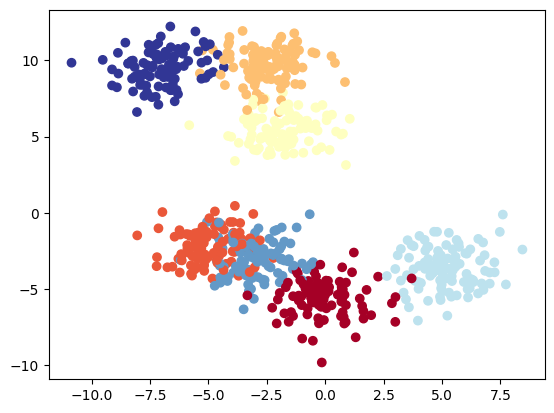

In [4]:
X_blob, y_blob = make_blobs(
                            n_samples=700,
                            n_features=2,
                            centers=7,
                            cluster_std=1.15,
                            center_box=(-10.0, 10.0),
                            shuffle=True,
                            random_state=50,
                            return_centers=False
                            )
plt.scatter(
          x=X_blob[:, 0],
          y=X_blob[:, 1],
          c=y_blob,
          cmap=plt.cm.RdYlBu
          );

## check data type

In [5]:
type(X_blob)

numpy.ndarray

## convert from nd.array to torch.tensor

In [6]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [7]:
type(X_blob)

torch.Tensor

## create train/test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                  X_blob,
                  y_blob,
                  train_size=0.8,
                  random_state=50
                  )

## create model for data analysis

In [9]:
class BlobModelV1(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.linear_layer = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer(x)

model_1 = BlobModelV1(2, 7).to(device)
model_1_str = str(model_1)
clean_model_1_str = model_1_str.replace("(", " ").replace(")", " ")

## define loss function and optimizer

In [10]:
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.015)
optimizer_1_class_name = optimizer_1.__class__.__name__
learning_rate_1 = optimizer_1.param_groups[0]["lr"]

## write training and test loop

In [11]:
torch.manual_seed(50)
torch.cuda.manual_seed(50)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs_count_1 = []
loss_values_1 = []
test_loss_values_1 = []
acc_values_1 = []
test_acc_values_1 = []

epochs_1 = 1050

for epoch_1 in range(epochs_1):
  model_1.train()
  y_logits = model_1(X_train)

  y_pred = torch.argmax(y_logits, dim=1)
  loss_1 = loss_fn_1(y_logits, y_train)

  acc_1 = accuracy_fn(y_train, y_pred)
  optimizer_1.zero_grad()
  loss_1.backward()
  optimizer_1.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test)

    test_pred = torch.argmax(test_logits, dim=1)
    test_loss_1 = loss_fn_1(test_logits, y_test)

    test_acc_1 = accuracy_fn(y_test, test_pred)

    if epoch_1 % 50 == 0:
      epochs_count_1.append(epoch_1)
      loss_values_1.append(loss_1)
      acc_values_1.append(acc_1)
      test_loss_values_1.append(test_loss_1)
      test_acc_values_1.append(test_acc_1)
      print(f"Epoch: {epoch_1} | Loss: {loss_1:.5f} | Acc: {acc_1:.2f} | Test Loss: {test_loss_1:.5f} | Test Acc: {test_acc_1:.2f}")

Epoch: 0 | Loss: 2.50183 | Acc: 17.68 | Test Loss: 2.48399 | Test Acc: 22.86
Epoch: 50 | Loss: 0.78862 | Acc: 71.79 | Test Loss: 0.77953 | Test Acc: 77.86
Epoch: 100 | Loss: 0.67116 | Acc: 76.96 | Test Loss: 0.68102 | Test Acc: 82.14
Epoch: 150 | Loss: 0.62026 | Acc: 77.32 | Test Loss: 0.63538 | Test Acc: 82.86
Epoch: 200 | Loss: 0.58837 | Acc: 78.93 | Test Loss: 0.60634 | Test Acc: 84.29
Epoch: 250 | Loss: 0.56539 | Acc: 80.54 | Test Loss: 0.58543 | Test Acc: 85.00
Epoch: 300 | Loss: 0.54752 | Acc: 81.25 | Test Loss: 0.56925 | Test Acc: 85.00
Epoch: 350 | Loss: 0.53292 | Acc: 81.96 | Test Loss: 0.55610 | Test Acc: 85.71
Epoch: 400 | Loss: 0.52057 | Acc: 82.68 | Test Loss: 0.54504 | Test Acc: 85.71
Epoch: 450 | Loss: 0.50988 | Acc: 83.21 | Test Loss: 0.53551 | Test Acc: 86.43
Epoch: 500 | Loss: 0.50042 | Acc: 83.75 | Test Loss: 0.52713 | Test Acc: 87.14
Epoch: 550 | Loss: 0.49195 | Acc: 84.29 | Test Loss: 0.51965 | Test Acc: 87.14
Epoch: 600 | Loss: 0.48426 | Acc: 84.46 | Test Loss: 0.

## plot training | test | accuracy over epochs

In [34]:
final_loss_1 = loss_values_1[-1]
final_test_loss_1 = test_loss_values_1[-1]
final_acc_1 = acc_values_1[-1]
final_test_acc_1 = test_acc_values_1[-1]

def model_eval(model, loss_val, test_loss_val, acc_val, test_acc_val):
    return {
        "Model": model.__class__.__name__,
        "Train Loss": loss_val.item(),
        "Test Loss": test_loss_val.item(),
        "Accuracy": acc_val,
        "Test Accuracy": test_acc_val
    }
model_1_eval = model_eval(model_1, final_loss_1, final_test_loss_1, final_acc_1, final_test_acc_1)
model_1_eval

{'Model': 'BlobModelV1',
 'Train Loss': 0.43946486711502075,
 'Test Loss': 0.4743114411830902,
 'Accuracy': 86.25,
 'Test Accuracy': 87.14285714285714}

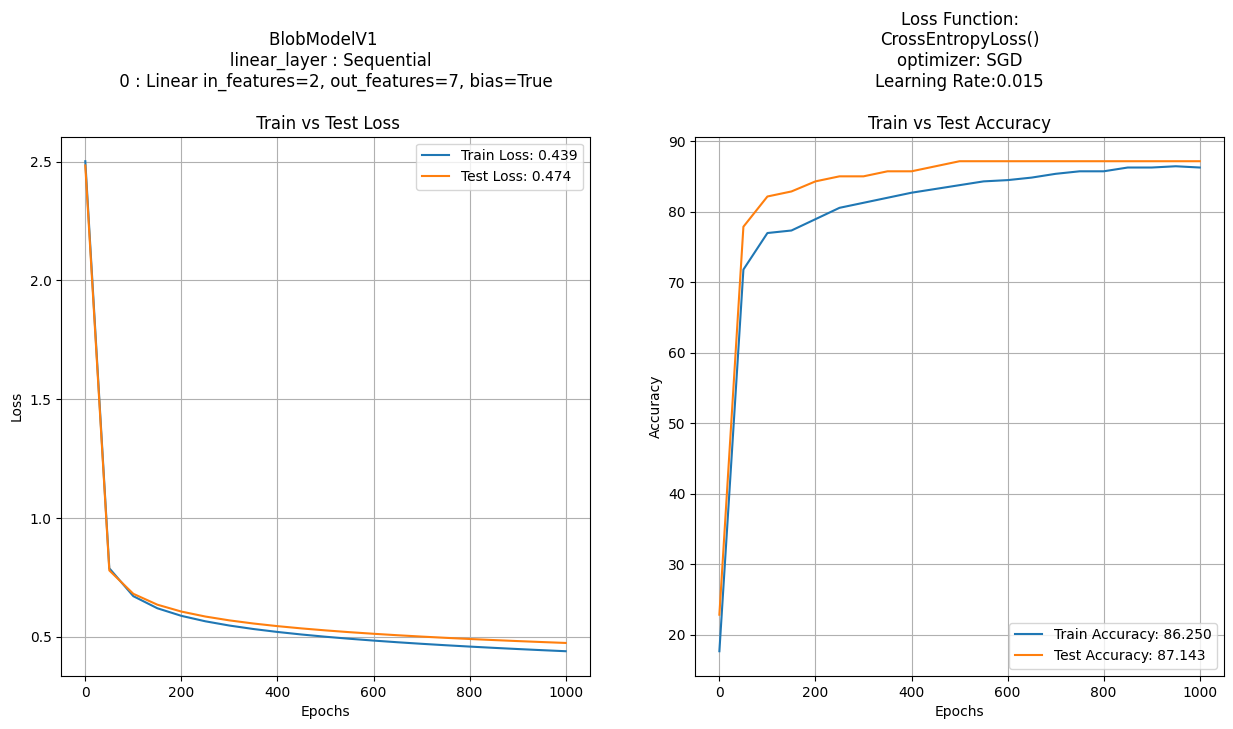

In [13]:


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(epochs_count_1, np.array(torch.tensor(loss_values_1).numpy()), label=f"Train Loss: {final_loss_1:.3f}")
plt.plot(epochs_count_1, np.array(torch.tensor(test_loss_values_1).numpy()), label=f"Test Loss: {final_test_loss_1:.3f}")
plt.title(f"\n{clean_model_1_str}Train vs Test Loss")
plt.xlabel(f"Epochs")
plt.ylabel("Loss")
plt.legend();
plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(epochs_count_1, np.array(torch.tensor(acc_values_1).numpy()), label=f"Train Accuracy: {final_acc_1:.3f}")
plt.plot(epochs_count_1, np.array(torch.tensor(test_acc_values_1).numpy()), label=f"Test Accuracy: {final_test_acc_1:.3f}")
plt.title(f"Loss Function:\n{loss_fn_1}\noptimizer: {optimizer_1_class_name}\nLearning Rate:{learning_rate_1}\n\nTrain vs Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();


## plot result 

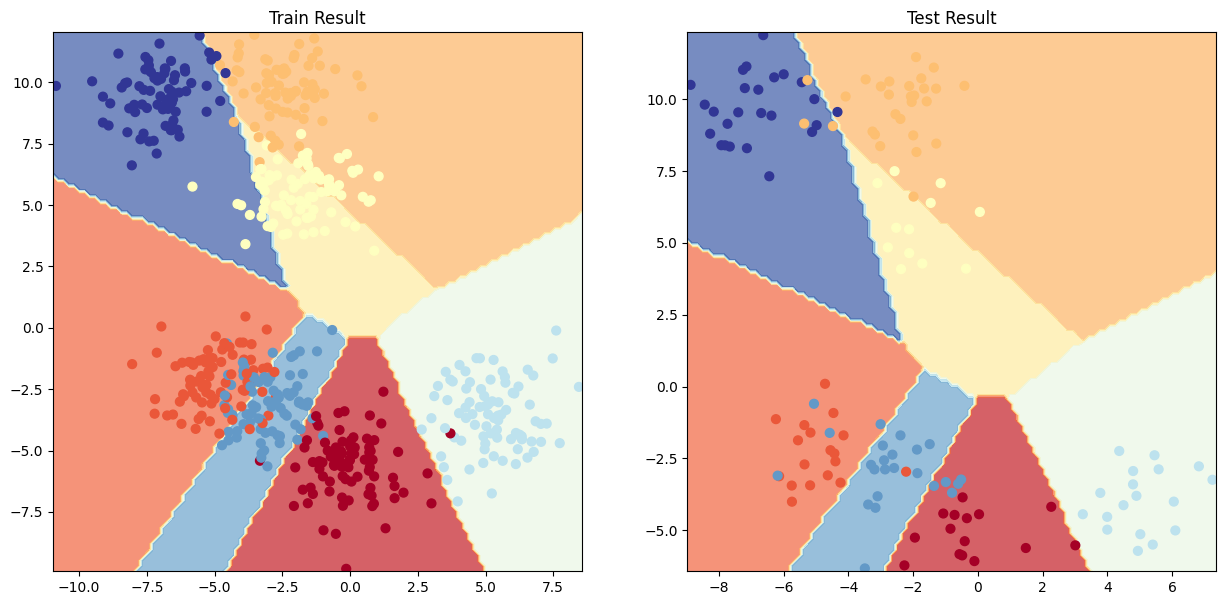

In [14]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Train Result")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test Result")
plot_decision_boundary(model_1, X_test, y_test)

In [15]:
class BlobModelV2(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=32),
            nn.Linear(in_features=32, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

model_2 = BlobModelV2(2, 7).to(device)

def formate_model_info(model_n):
    model_str = str(model_n)
    cleaned_model_str = model_str.replace("(", " ").replace(")", " ")
    return cleaned_model_str
model_2_info = formate_model_info(model_2)

In [16]:
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.015)

def format_optimizer_info(optimizer_n):
    optimizer_name = optimizer_n.__class__.__name__
    learning_rate = optimizer_n.param_groups[0]["lr"]
    return optimizer_name, learning_rate
optim_2_name, optim_2_rate = format_optimizer_info(optimizer_2)

In [17]:
def train_steps(model, loss_fn, optimizer, accuracy_fn, X_train, y_train):
    model.train()
    y_logits = model(X_train)
    loss = loss_fn(y_logits, y_train)
    y_pred = torch.argmax(y_logits, dim=1)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), acc
    

def test_steps(model, loss_fn, accuracy_fn, X_test, y_test):
    model.eval()
    with torch.inference_mode():
      test_logits = model(X_test)
      test_loss = loss_fn(test_logits, y_test)
      test_pred = torch.argmax(test_logits, dim=1)
      test_acc = accuracy_fn(y_test, test_pred)

    return test_loss.item(), test_acc

In [18]:
def train_loop(model, loss_fn, optimizer, accuracy_fn, 
               X_train, X_test, y_train, y_test, 
               num_epochs, print_freq, device=None):
    
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    collect_epochs = []
    loss_values = []
    acc_values = []
    test_loss_values = []
    test_acc_values = []

    for epoche in range(num_epochs):
        loss, acc = train_steps(model, loss_fn, optimizer, accuracy_fn,
                                X_train, y_train)
        test_loss, test_acc = test_steps(model, loss_fn, accuracy_fn, 
                                         X_test, y_test)
        
        if epoche % print_freq == 0:
            collect_epochs.append(epoche) 
            loss_values.append(loss)
            test_loss_values.append(test_loss)
            acc_values.append(acc)
            test_acc_values.append(test_acc)
            print(f"Epoch: {epoche} | Loss: {loss:.3f} | Acc: {acc:.3f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}")

    
    return collect_epochs, loss_values, test_loss_values, acc_values, test_acc_values

In [19]:
epochs_count_2, loss_values_2, test_loss_values_2, acc_values_2, test_acc_values_2 = train_loop(model_2, loss_fn_2, optimizer_2, accuracy_fn,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test,
                             device=device,
                             num_epochs=1050,
                             print_freq=50)


Epoch: 0 | Loss: 3.728 | Acc: 0.714 | Test Loss: 2.462 | Test Acc: 22.857
Epoch: 50 | Loss: 0.628 | Acc: 75.714 | Test Loss: 0.645 | Test Acc: 78.571
Epoch: 100 | Loss: 0.532 | Acc: 81.250 | Test Loss: 0.557 | Test Acc: 83.571
Epoch: 150 | Loss: 0.482 | Acc: 83.393 | Test Loss: 0.512 | Test Acc: 85.714
Epoch: 200 | Loss: 0.447 | Acc: 84.107 | Test Loss: 0.483 | Test Acc: 85.714
Epoch: 250 | Loss: 0.421 | Acc: 85.179 | Test Loss: 0.461 | Test Acc: 87.857
Epoch: 300 | Loss: 0.400 | Acc: 87.679 | Test Loss: 0.444 | Test Acc: 87.857
Epoch: 350 | Loss: 0.382 | Acc: 88.214 | Test Loss: 0.429 | Test Acc: 87.143
Epoch: 400 | Loss: 0.367 | Acc: 89.286 | Test Loss: 0.417 | Test Acc: 87.857
Epoch: 450 | Loss: 0.354 | Acc: 89.643 | Test Loss: 0.406 | Test Acc: 87.857
Epoch: 500 | Loss: 0.342 | Acc: 89.643 | Test Loss: 0.397 | Test Acc: 87.857
Epoch: 550 | Loss: 0.331 | Acc: 89.821 | Test Loss: 0.389 | Test Acc: 88.571
Epoch: 600 | Loss: 0.321 | Acc: 89.821 | Test Loss: 0.381 | Test Acc: 88.571
Epo

None


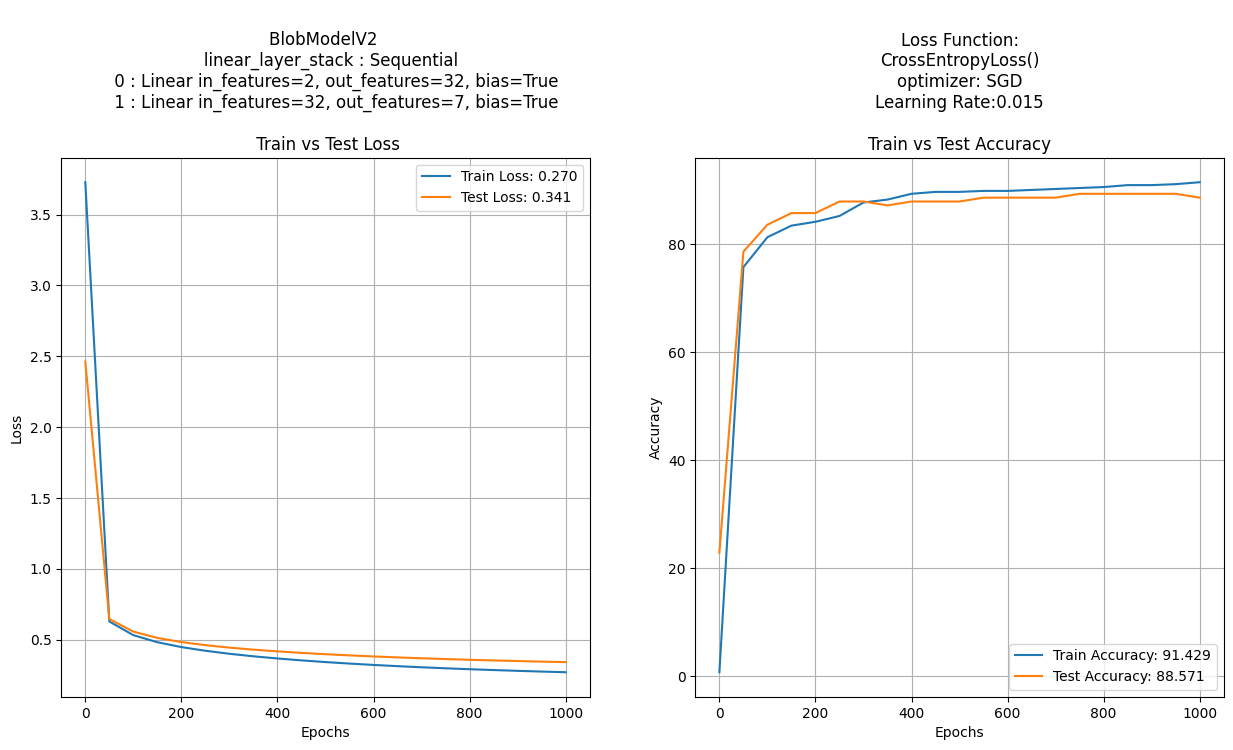

In [20]:
def plot_loss_accuracy(all_epochs, all_losses, all_test_losses, all_accs, all_test_accs, model_info, loss_func, optim, learn):

    final_loss = all_losses[-1]
    final_test_loss = all_test_losses[-1]
    final_acc = all_accs[-1]
    final_test_acc = all_test_accs[-1]

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.grid(True)
    plt.plot(all_epochs, np.array(torch.tensor(all_losses).numpy()), label=f"Train Loss: {final_loss:.3f}")
    plt.plot(all_epochs, np.array(torch.tensor(all_test_losses).numpy()), label=f"Test Loss: {final_test_loss:.3f}")
    plt.title(f"\n{model_info}Train vs Test Loss")
    plt.xlabel(f"Epochs")
    plt.ylabel("Loss")
    plt.legend();
    plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.plot(all_epochs, np.array(torch.tensor(all_accs).numpy()), label=f"Train Accuracy: {final_acc:.3f}")
    plt.plot(all_epochs, np.array(torch.tensor(all_test_accs).numpy()), label=f"Test Accuracy: {final_test_acc:.3f}")
    plt.title(f"Loss Function:\n{loss_func}\noptimizer: {optim}\nLearning Rate:{learn}\n\nTrain vs Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend();
print(plot_loss_accuracy(epochs_count_2, loss_values_2, test_loss_values_2, acc_values_2, test_acc_values_2, model_2_info, loss_fn_2, optim_2_name, optim_2_rate))

None


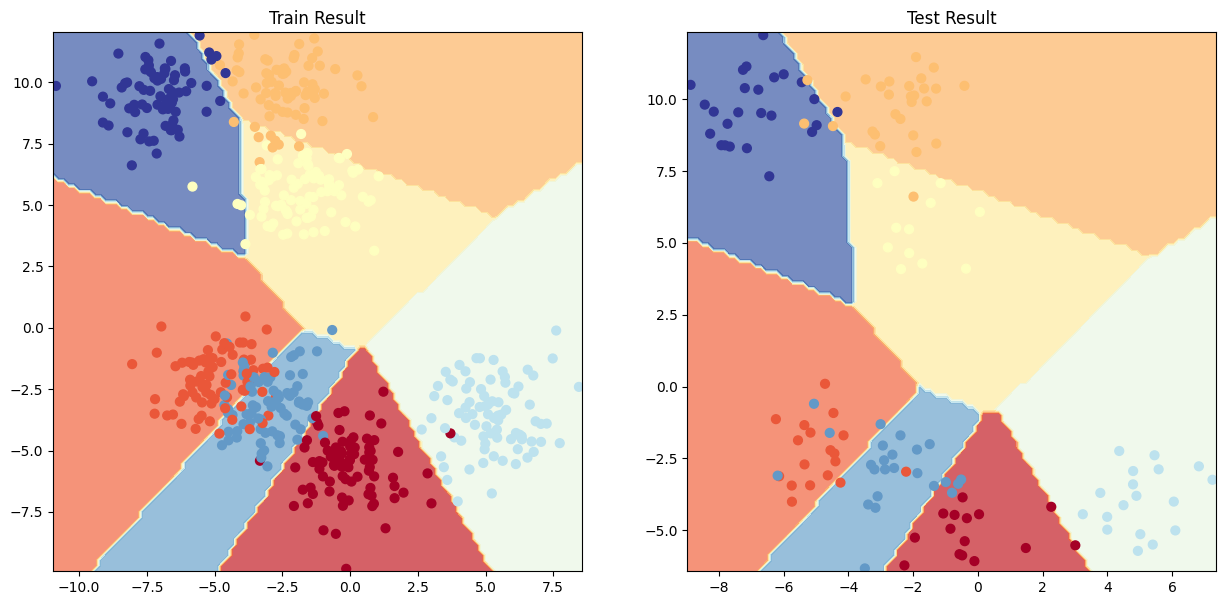

In [21]:
def plot_result(model):
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.title("Train Result")
    plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test Result")
    plot_decision_boundary(model, X_test, y_test)
print(plot_result(model_2))

In [22]:
class BlobModelV3(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=32),
            nn.Linear(in_features=32, out_features=32),
            nn.Linear(in_features=32, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

model_3 = BlobModelV3(2, 7).to(device)
model_3_info = formate_model_info(model_3)

In [23]:
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.SGD(params=model_3.parameters(),
                              lr=0.015)
optim_3_name, optim_3_rate = format_optimizer_info(optimizer_3)

In [24]:
epochs_count_3, loss_values_3, test_loss_values_3, acc_values_3, test_acc_values_3 = train_loop(model_3, loss_fn_3, optimizer_3, accuracy_fn, 
                                                                                                X_train=X_train,
                                                                                                X_test=X_test,
                                                                                                y_train=y_train,
                                                                                                y_test=y_test,
                                                                                                device=device,
                                                                                                num_epochs=1050,
                                                                                                print_freq=50)

Epoch: 0 | Loss: 2.521 | Acc: 0.536 | Test Loss: 2.053 | Test Acc: 17.857
Epoch: 50 | Loss: 0.642 | Acc: 71.607 | Test Loss: 0.658 | Test Acc: 74.286
Epoch: 100 | Loss: 0.533 | Acc: 76.964 | Test Loss: 0.558 | Test Acc: 77.857
Epoch: 150 | Loss: 0.481 | Acc: 80.000 | Test Loss: 0.512 | Test Acc: 83.571
Epoch: 200 | Loss: 0.447 | Acc: 81.964 | Test Loss: 0.484 | Test Acc: 84.286
Epoch: 250 | Loss: 0.420 | Acc: 82.679 | Test Loss: 0.464 | Test Acc: 85.000
Epoch: 300 | Loss: 0.398 | Acc: 83.929 | Test Loss: 0.447 | Test Acc: 84.286
Epoch: 350 | Loss: 0.378 | Acc: 85.893 | Test Loss: 0.433 | Test Acc: 85.714
Epoch: 400 | Loss: 0.360 | Acc: 87.679 | Test Loss: 0.419 | Test Acc: 87.143
Epoch: 450 | Loss: 0.343 | Acc: 89.286 | Test Loss: 0.407 | Test Acc: 86.429
Epoch: 500 | Loss: 0.328 | Acc: 89.643 | Test Loss: 0.395 | Test Acc: 86.429
Epoch: 550 | Loss: 0.313 | Acc: 90.000 | Test Loss: 0.384 | Test Acc: 87.143
Epoch: 600 | Loss: 0.300 | Acc: 90.000 | Test Loss: 0.373 | Test Acc: 87.143
Epo

None
None


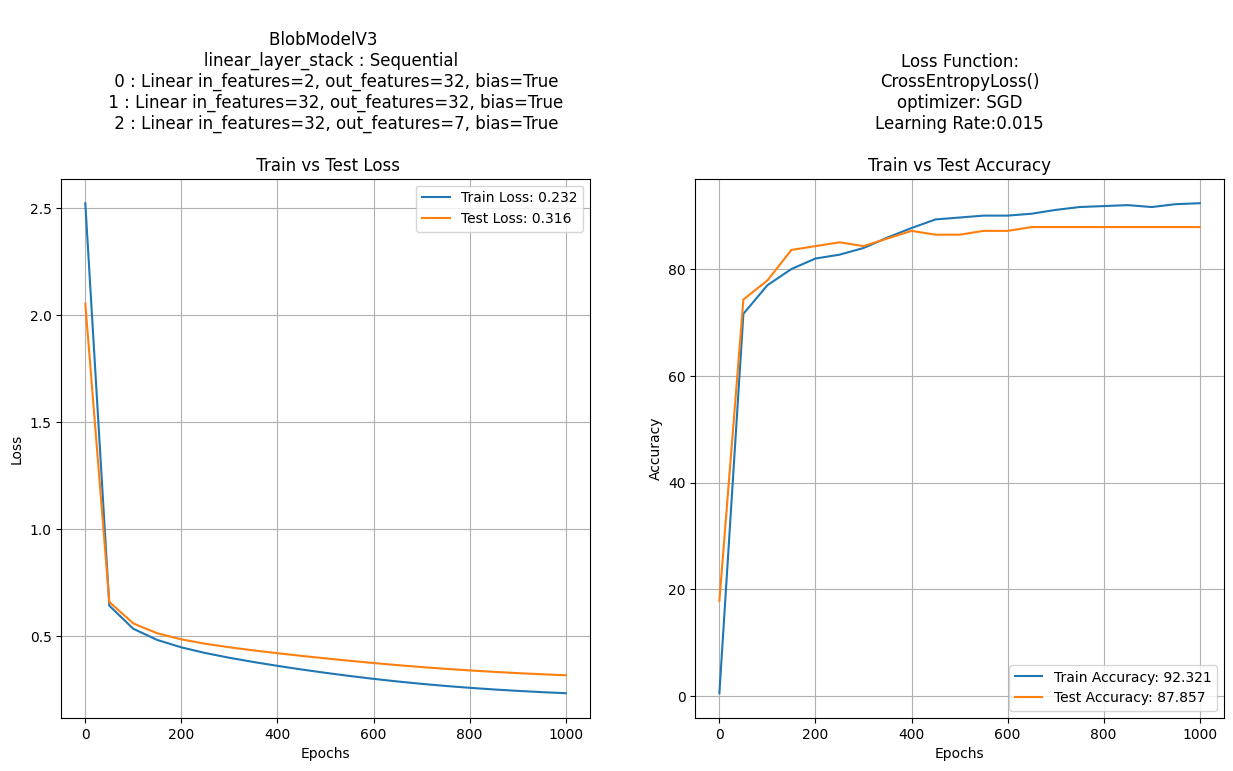

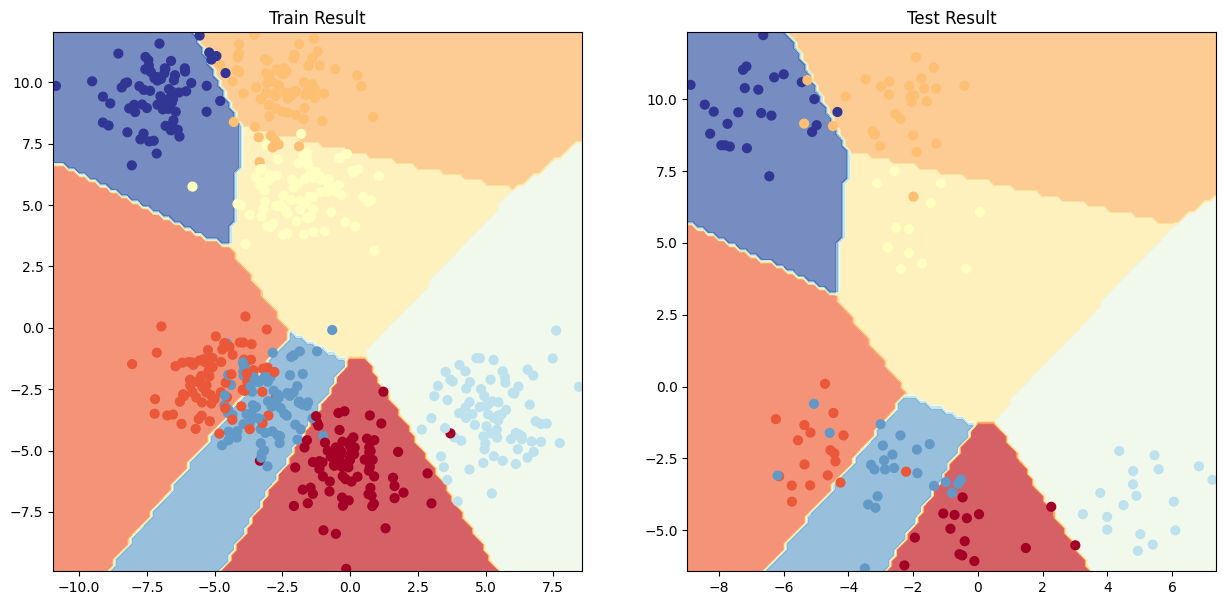

In [25]:
print(plot_loss_accuracy(epochs_count_3, loss_values_3, test_loss_values_3, acc_values_3, test_acc_values_3, model_3_info, loss_fn_3, optim_3_name, optim_3_rate))
print(plot_result(model_3))

In [26]:
class BlobModelV4(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_features)
        )
    def forward(self, x):
        return self.layer_stack(x)

model_4 = BlobModelV4(2, 7).to(device)
model_4_info = formate_model_info(model_4)

In [27]:
loss_fn_4 = nn.CrossEntropyLoss()
optimizer_4 = torch.optim.SGD(params=model_4.parameters(),
                              lr=0.015)
optim_4_name, optim_4_rate = format_optimizer_info(optimizer_4)

In [28]:
epochs_count_4, loss_values_4, test_loss_values_4, acc_values_4, test_acc_values_4 = train_loop(model_4, loss_fn_4, optimizer_4, accuracy_fn,
                                                                                                X_train=X_train,
                                                                                                X_test=X_test,
                                                                                                y_train=y_train,
                                                                                                y_test=y_test,
                                                                                                device=device,
                                                                                                num_epochs=1050,
                                                                                                print_freq=50)

Epoch: 0 | Loss: 1.937 | Acc: 0.179 | Test Loss: 1.887 | Test Acc: 1.429
Epoch: 50 | Loss: 1.118 | Acc: 63.750 | Test Loss: 1.117 | Test Acc: 67.143
Epoch: 100 | Loss: 0.778 | Acc: 70.893 | Test Loss: 0.807 | Test Acc: 72.143
Epoch: 150 | Loss: 0.613 | Acc: 76.964 | Test Loss: 0.654 | Test Acc: 77.857
Epoch: 200 | Loss: 0.530 | Acc: 80.179 | Test Loss: 0.576 | Test Acc: 81.429
Epoch: 250 | Loss: 0.482 | Acc: 81.250 | Test Loss: 0.532 | Test Acc: 82.857
Epoch: 300 | Loss: 0.452 | Acc: 81.786 | Test Loss: 0.506 | Test Acc: 83.571
Epoch: 350 | Loss: 0.431 | Acc: 82.143 | Test Loss: 0.489 | Test Acc: 82.857
Epoch: 400 | Loss: 0.416 | Acc: 82.857 | Test Loss: 0.477 | Test Acc: 83.571
Epoch: 450 | Loss: 0.404 | Acc: 82.679 | Test Loss: 0.468 | Test Acc: 83.571
Epoch: 500 | Loss: 0.394 | Acc: 83.571 | Test Loss: 0.461 | Test Acc: 83.571
Epoch: 550 | Loss: 0.385 | Acc: 84.107 | Test Loss: 0.456 | Test Acc: 83.571
Epoch: 600 | Loss: 0.378 | Acc: 84.107 | Test Loss: 0.451 | Test Acc: 84.286
Epoc

None
None


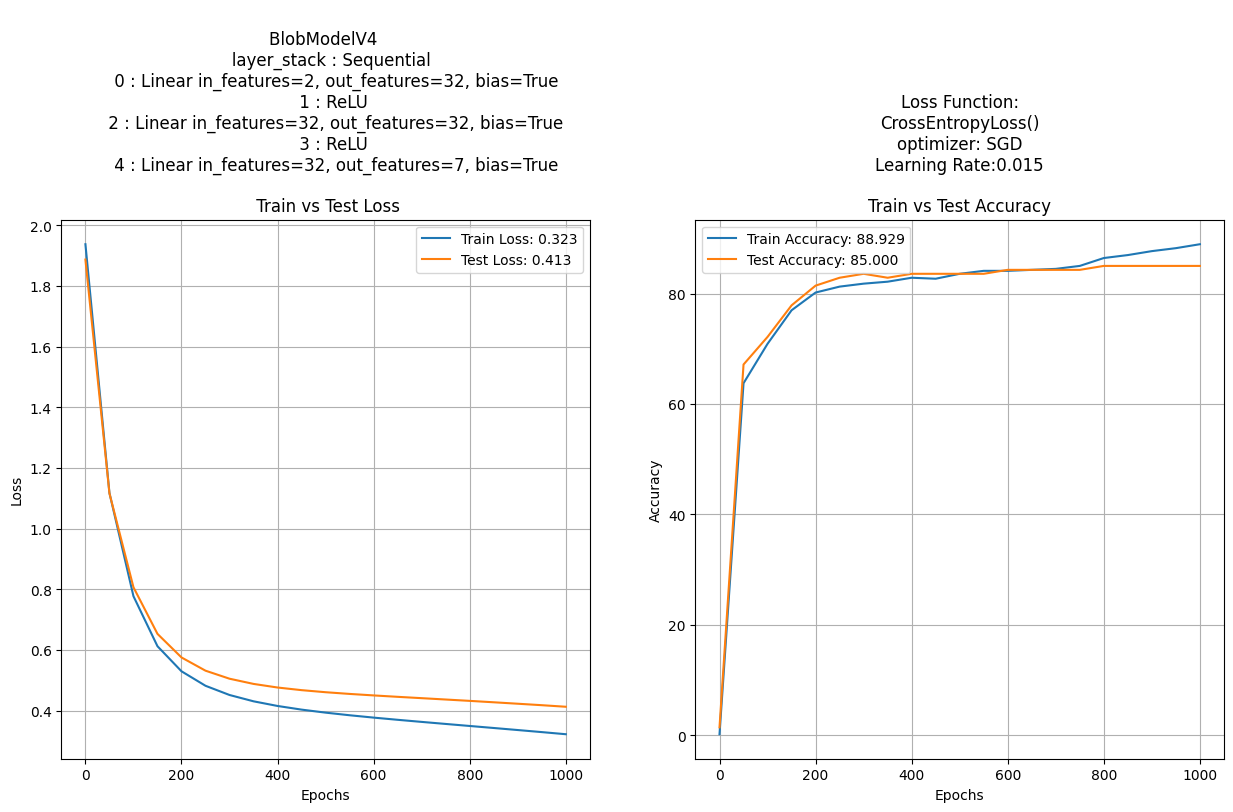

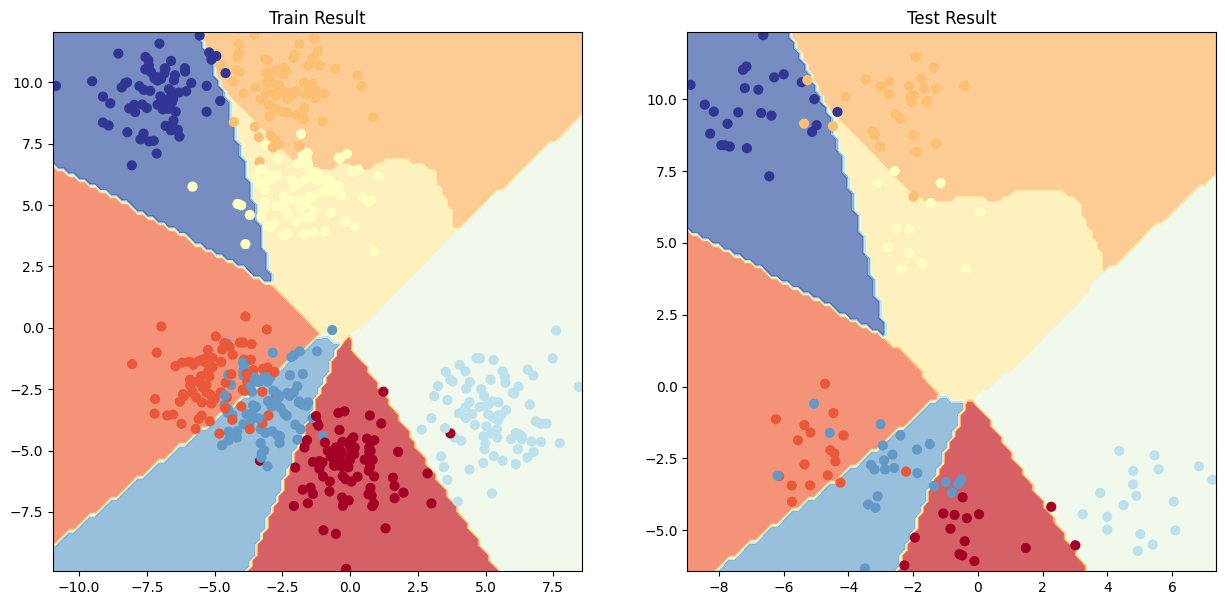

In [29]:
print(plot_loss_accuracy(epochs_count_4, loss_values_4, test_loss_values_4, acc_values_4, test_acc_values_4, model_4_info, loss_fn_4, optim_4_name, optim_4_rate))
print(plot_result(model_4))

In [30]:
class BlobModelV5(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self. layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=64),
            nn.GELU(),
            nn.Linear(in_features=64, out_features=128),
            nn.GELU(),
            nn.Linear(in_features=128, out_features=64),
            nn.GELU(),
            nn.Linear(in_features=64, out_features=output_features)
        )
    def forward(self, x):
        return self.layer_stack(x)

model_5 = BlobModelV5(2, 7).to(device)
model_5_info = formate_model_info(model_5)

In [31]:
loss_fn_5 = nn.CrossEntropyLoss()
optimizer_5 = torch.optim.SGD(params=model_5.parameters(),
                              lr=0.015)
optim_5_name, optim_5_rate = format_optimizer_info(optimizer_5)

In [32]:
epochs_count_5, loss_values_5, test_loss_values_5, acc_values_5, test_acc_values_5 = train_loop(model_5, loss_fn_5, optimizer_5, accuracy_fn,
                                                                                                X_train=X_train,
                                                                                                X_test=X_test,
                                                                                                y_train=y_train,
                                                                                                y_test=y_test,
                                                                                                device=device,
                                                                                                num_epochs=2050,
                                                                                                print_freq=50)

Epoch: 0 | Loss: 1.959 | Acc: 13.929 | Test Loss: 1.925 | Test Acc: 15.714
Epoch: 50 | Loss: 1.093 | Acc: 69.107 | Test Loss: 1.050 | Test Acc: 70.714
Epoch: 100 | Loss: 0.680 | Acc: 74.286 | Test Loss: 0.684 | Test Acc: 75.714
Epoch: 150 | Loss: 0.512 | Acc: 82.679 | Test Loss: 0.536 | Test Acc: 85.714
Epoch: 200 | Loss: 0.435 | Acc: 84.821 | Test Loss: 0.471 | Test Acc: 86.429
Epoch: 250 | Loss: 0.392 | Acc: 86.250 | Test Loss: 0.437 | Test Acc: 85.714
Epoch: 300 | Loss: 0.363 | Acc: 88.571 | Test Loss: 0.416 | Test Acc: 85.714
Epoch: 350 | Loss: 0.341 | Acc: 89.643 | Test Loss: 0.401 | Test Acc: 85.714
Epoch: 400 | Loss: 0.323 | Acc: 90.179 | Test Loss: 0.389 | Test Acc: 86.429
Epoch: 450 | Loss: 0.308 | Acc: 90.714 | Test Loss: 0.379 | Test Acc: 86.429
Epoch: 500 | Loss: 0.294 | Acc: 90.893 | Test Loss: 0.370 | Test Acc: 87.143
Epoch: 550 | Loss: 0.281 | Acc: 91.429 | Test Loss: 0.362 | Test Acc: 87.143
Epoch: 600 | Loss: 0.270 | Acc: 92.143 | Test Loss: 0.354 | Test Acc: 87.143
Ep

None
None


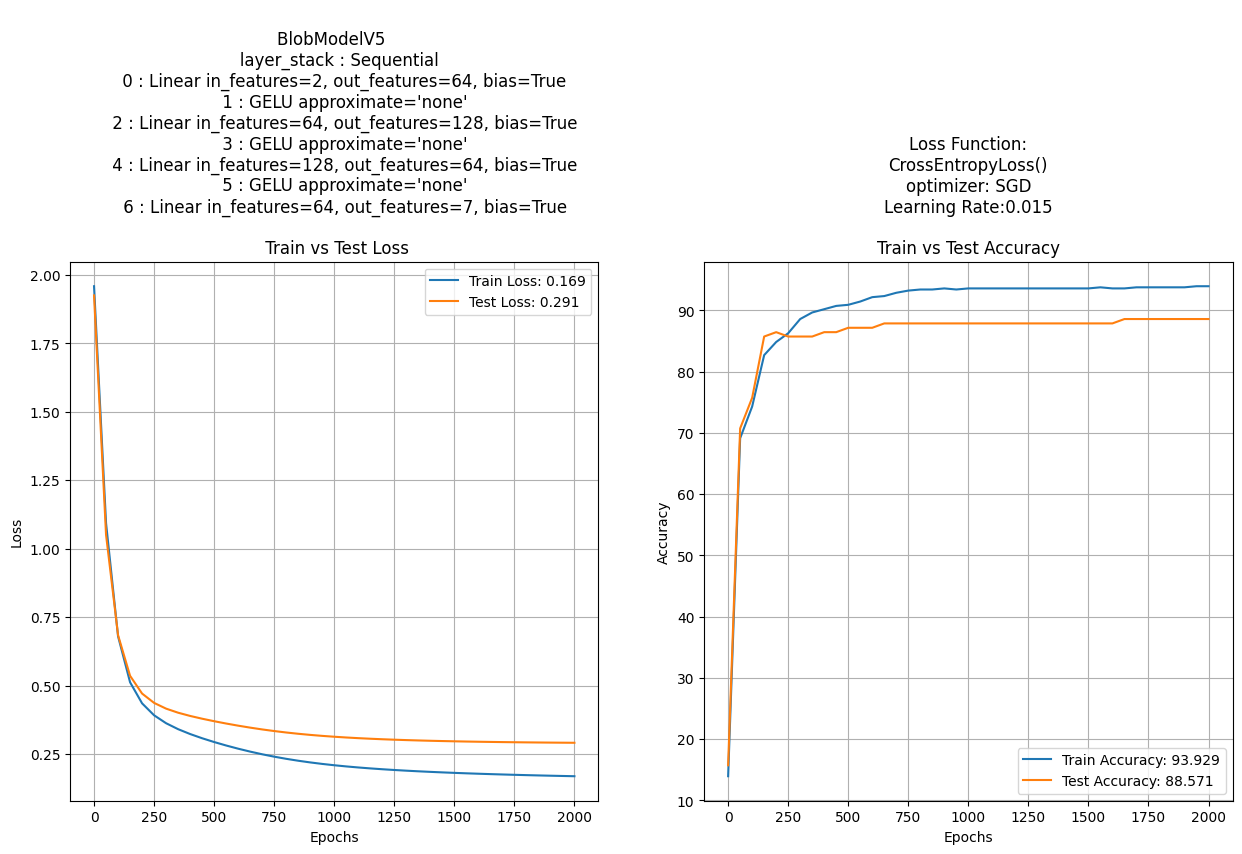

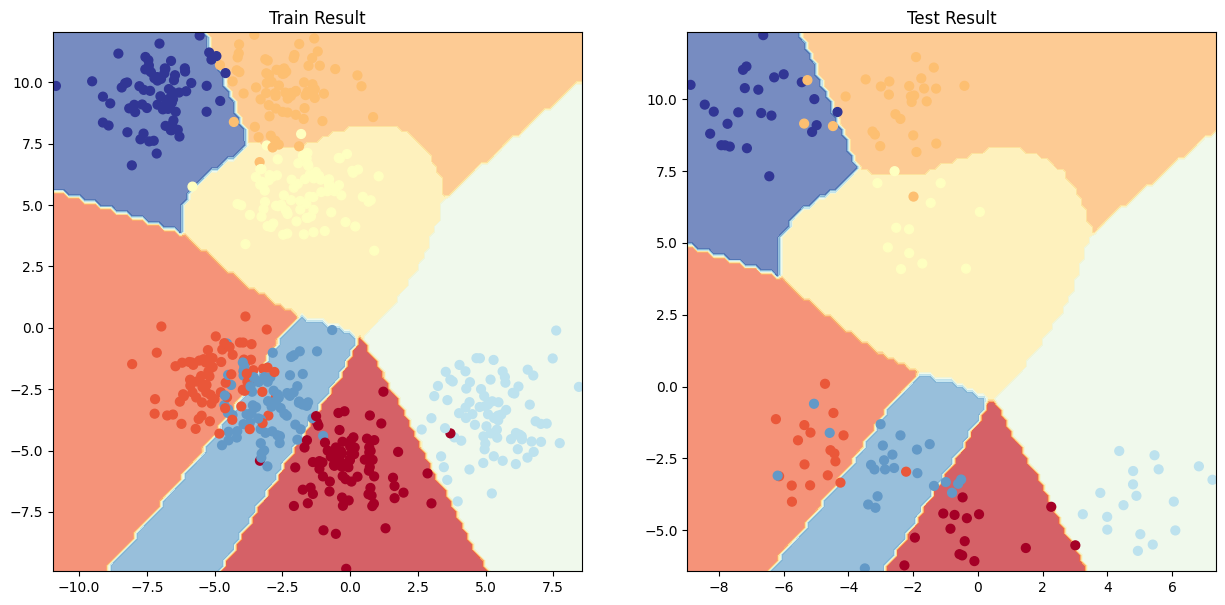

In [33]:
print(plot_loss_accuracy(epochs_count_5, loss_values_5, test_loss_values_5, acc_values_5, test_acc_values_5, model_5_info, loss_fn_5, optim_5_name, optim_5_rate))
print(plot_result(model_5))